In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict Tensorflow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initailized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData_bert.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [5]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [6]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def random_jitter(img):
    # resizeing to 72 x 72 x 3
    img = tf.image.resize(img, [72, 72], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 64 x 64 x 3
    img = tf.image.random_crop(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    # random mirroring
    img = tf.image.random_flip_left_right(img)

    return img

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    #-------------------------------------
    # Data Augmentation
    img = random_jitter(img)
    # Normalizing the image to [-1, 1]
    img = (img * 2.0) - 1
    #-------------------------------------
    caption = tf.cast(caption, tf.float32)

    return img, caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    caption = df['Captions'].values
    caption = np.stack(caption)
    image_path = df['ImagePath'].values
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [7]:
BATCH_SIZE = 64
dataset = dataset_generator(data_path + '/text2ImgData_bert.pkl', BATCH_SIZE, training_data_generator)

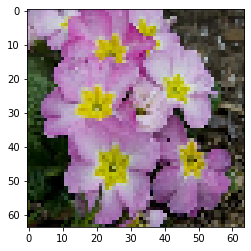

In [8]:
for image, caption in dataset.take(1):
    data = (image[0].numpy() + 1.0) / 2.0
    plt.imshow(data)

In [9]:
class ResidualBlocks(tf.keras.Model):
    def __init__(self, num_blocks):
        super(ResidualBlocks, self).__init__()
        self.num_blocks = num_blocks
        self.block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME'),
            tf.keras.layers.BatchNormalization(momentum=0.8),
            tf.keras.layers.PReLU(shared_axes=[1, 2]),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME'),
            tf.keras.layers.BatchNormalization(momentum=0.8),
        ])
        
    def call(self, x):
        for _ in range(self.num_blocks):
            x = tf.keras.layers.Add()([x, self.block(x)])
        return x
    
    def summary(self):
        x = tf.keras.Input(shape=[None, None, 64])
        tf.keras.Model(inputs=x, outputs=self.call(x)).summary()

class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        xh, xw, xc = self.hparas['IMAGE_SIZE']
        zh, zw = xh // 4, xw // 4

        self.text_channel = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=zh * zw * 32),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(zh, zw, 32)),
        ])

        self.noise_channel = tf.keras.Sequential([
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=zh * zw * 128),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(zh, zw, 128))
        ])
        
        self.conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME')
        self.residual_blocks = ResidualBlocks(num_blocks=8)

        self.upsample = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="SAME"),
            tf.keras.layers.Conv2D(filters=xc, kernel_size=3, strides=1, padding='SAME', activation='tanh')
        ])

    def call(self, text, noise_z):
        text = self.text_channel(text)
        noise_z = self.noise_channel(noise_z)
        
        # concatenate input text and random noise
        x = tf.concat([noise_z, text], axis=-1)
        
        x = self.conv(x)
        x = self.residual_blocks(x)
        
        logits = None
        output = self.upsample(x)
        
        return logits, output
        

In [10]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        xh, xw, xc = self.hparas['IMAGE_SIZE']

        self.text_channel = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=xh * xw),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(xh, xw, 1))
        ])
        
        self.discriminator = tf.keras.Sequential([
            # dowensample
            tf.keras.layers.Conv2D(filters=64 , kernel_size=3, strides=2, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            # flatten feature maps
            tf.keras.layers.Flatten(),
            # dropout
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=1)
        ])

    def call(self, img, text):
        text = self.text_channel(text)
        # concatenate image with paired text
        img_text = tf.concat([text, img], axis=-1)
        
        logits = self.discriminator(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [11]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 768,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 2e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 600,
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/bert_dcgan',  # checkpoint path
    'PRINT_FREQ': 1                           # printing frequency of loss
}

In [12]:
generator = Generator(hparas)
discriminator = Discriminator(hparas)

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [14]:
loss_type = 'hinge'

def discriminator_loss(real_logits, fake_logits):
    if loss_type == 'gan':
        real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
        fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
        
    if loss_type == 'lsgan':
        real_loss = tf.reduce_mean(tf.math.squared_difference(real_logits, 1.0))
        fake_loss = tf.reduce_mean(tf.square(fake_logits))
        
    if loss_type == 'hinge':
        real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_logits))
        fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_logits))
        
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    if loss_type == 'gan':
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    if loss_type == 'lsgan':
        return tf.reduce_mean(tf.math.squared_difference(fake_output, 1.0))
    
    if loss_type == 'hinge':
        return -tf.reduce_mean(fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'], beta_1=hparas['BETA_1'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'], beta_1=hparas['BETA_1'])

In [17]:
# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.restore(checkpoint_prefix + "-12")

In [18]:
@tf.function
def test_step(caption, noise):
    text_embed = caption
    _, fake_image = generator(text_embed, noise)
    return fake_image

In [172]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imshow(images, size):
    plt.figure(figsize=(8, 8))
    return plt.imshow(merge(images, size)*0.5 + 0.5)

def show_images(images, size):
    return imshow(images, size)

In [126]:
def caption_to_sentence(caption):
    return ' '.join([id2word_dict[wordId] for wordId in caption if wordId not in ['0', '5427', '5428']])

def testing_data_generator(embedding, index, caption):
    embedding = tf.cast(embedding, tf.float32)
    return embedding, index, caption

def testing_dataset_generator(batch_size, data_generator, indices):
    data = pd.read_pickle('./dataset/testData_bert.pkl')
    embedding = np.stack(data['Captions'].values)[indices]
    index = data['ID'].values
    index = np.asarray(index)[indices]
    
    data = pd.read_pickle('./dataset/testData.pkl')
    captions = np.stack(data['Captions'].values)[indices]
    captions = [caption_to_sentence(caption) for caption in captions]
    
    dataset = tf.data.Dataset.from_tensor_slices((embedding, index, captions))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat(5).batch(batch_size)
    
    return dataset

testing_dataset = testing_dataset_generator(5, testing_data_generator, [0, 1, 2, 3, 4])

Column 0 : this white and purple flower has fragile petals and soft stamens
Column 1 : this flower has four large wide pink petals with white centers and vein like markings
Column 2 : a flower with broad white and pink ribbed petals and yellow stamen
Column 3 : one prominet pistil with alarger stigam and many stamens with anthers
Column 4 : leaves are green in color petals are light pink in color


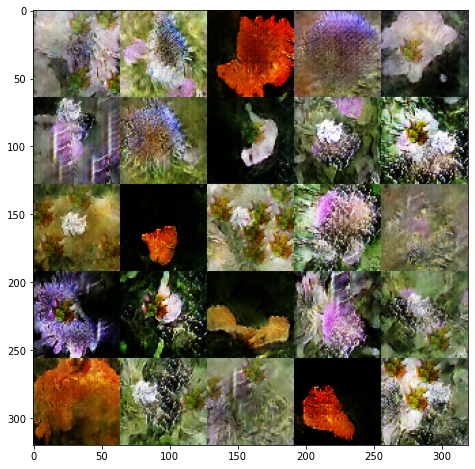

In [180]:
def inference(dataset):
    sample_size = 5
    fake_images = []
    for embeddings, idx, captions in dataset:
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image = test_step(embeddings, sample_seed)
        fake_images.append(fake_image)
    
    for i, sent in enumerate(captions.numpy()):
        print(f"Column {i} : " + sent.decode('utf-8'))
    fake_images = tf.concat(fake_images, axis=0)
    show_images(fake_images, [5, 5])

inference(testing_dataset)

### DCGAN

In [ ]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        xh, xw, xc = self.hparas['IMAGE_SIZE']
        zh, zw = xh // 4, xw // 4

        self.text_channel = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=zh * zw * 32),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(zh, zw, 32))
        ])
        
        self.noise_channel = tf.keras.Sequential([
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=zh * zw * 256),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(zh, zw, 256))
        ])

        self.upsample = tf.keras.Sequential([            
            tf.keras.layers.Conv2DTranspose(
                filters=32,
                kernel_size=3,
                strides=2,
                padding="SAME"
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME"),
            tf.keras.layers.Conv2D(filters=64 , kernel_size=3, strides=1, padding="SAME"),
            tf.keras.layers.Conv2D(filters=32 , kernel_size=3, strides=1, padding="SAME"),
            
            tf.keras.layers.Conv2DTranspose(
                filters=xc,
                kernel_size=3,
                strides=2,
                padding="SAME",
                activation=tf.keras.activations.tanh
            )
        ])

    def call(self, text, noise_z):
        text = self.text_channel(text)
        noise_z = self.noise_channel(noise_z)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=-1)
        
        logits = None
        output = self.upsample(text_concat)
        
        return logits, output
        

In [ ]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        xh, xw, xc = self.hparas['IMAGE_SIZE']

        self.text_channel = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=xh * xw),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(xh, xw, 1))
        ])
        
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding="SAME"),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding="SAME"),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding="SAME"),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=1)
        ])

    def call(self, img, text):
        text = self.text_channel(text)
        # concatenate image with paired text
        img_text = tf.concat([text, img], axis=-1)
        
        logits = self.discriminator(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [ ]:
def discriminator_loss(real_logits, fake_logits):
    if loss_type == 'gan':
        real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
        fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    if loss_type == 'gan':
        return cross_entropy(tf.ones_like(fake_output), fake_output)

### WGAN

In [ ]:
@tf.function
def gen_train(real_image, text_embed):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as gen_tape:
        _, fake_image = generator(text_embed, noise, training=True)
        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)

        d_loss = tf.reduce_mean(fake_logits)
        g_loss = -d_loss
        d_loss = d_loss - tf.reduce_mean(real_logits)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))

    return g_loss, d_loss

@tf.function
def disc_train(real_image, text_embed):
    # random noise for discriminator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as disc_tape:
        _, fake_image = generator(text_embed, noise, training=True)
        real_logits, real_output = discriminator(real_image, text_embed, training=True)
        fake_logits, fake_output = discriminator(fake_image, text_embed, training=True)

        d_loss = tf.reduce_mean(fake_logits)
        g_loss = -d_loss
        d_loss = d_loss - tf.reduce_mean(real_logits)

    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))

    # clipping
    for v in discriminator.trainable_variables:
        v.assign(tf.clip_by_value(v, -0.01, 0.01))

    return g_loss, d_loss

### LSGAN

In [ ]:
def discriminator_loss(real_logits, fake_logits):        
    if loss_type == 'lsgan':
        real_loss = tf.reduce_mean(tf.math.squared_difference(real_logits, 1.0))
        fake_loss = tf.reduce_mean(tf.square(fake_logits))
        
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    if loss_type == 'lsgan':
        return tf.reduce_mean(tf.math.squared_difference(fake_output, 1.0))

### SRGAN

SRGAN 是 Super-Resolution GAN，目的是希望產生質量更高的圖片。其架構主要的差異是在 Generator 的部分使用 Residual Block，讓 input 在進入 upsampling layers 之前先輸入數層的 Residual Blocks。另外在 Loss 的部分是使用 Hinge Loss ，這個 Loss 在 SAGAN 以及 BigGAN 中都被使用。

In [ ]:
class ResidualBlocks(tf.keras.Model):
    def __init__(self, num_blocks):
        super(ResidualBlocks, self).__init__()
        self.num_blocks = num_blocks
        self.block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME'),
            tf.keras.layers.BatchNormalization(momentum=0.8),
            tf.keras.layers.PReLU(shared_axes=[1, 2]),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME'),
            tf.keras.layers.BatchNormalization(momentum=0.8),
        ])
        
    def call(self, x):
        for _ in range(self.num_blocks):
            x = tf.keras.layers.Add()([x, self.block(x)])
        return x
    
    def summary(self):
        x = tf.keras.Input(shape=[None, None, 64])
        tf.keras.Model(inputs=x, outputs=self.call(x)).summary()

class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        xh, xw, xc = self.hparas['IMAGE_SIZE']
        zh, zw = xh // 4, xw // 4

        self.text_channel = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=zh * zw * 32),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(zh, zw, 32)),
        ])

        self.noise_channel = tf.keras.Sequential([
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=zh * zw * 128),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(zh, zw, 128))
        ])
        
        self.conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME')
        self.residual_blocks = ResidualBlocks(num_blocks=8)

        self.upsample = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="SAME"),
            tf.keras.layers.Conv2D(filters=xc, kernel_size=3, strides=1, padding='SAME', activation='tanh')
        ])

    def call(self, text, noise_z):
        text = self.text_channel(text)
        noise_z = self.noise_channel(noise_z)
        
        # concatenate input text and random noise
        x = tf.concat([noise_z, text], axis=-1)
        
        x = self.conv(x)
        x = self.residual_blocks(x)
        
        logits = None
        output = self.upsample(x)
        
        return logits, output
        

In [ ]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        xh, xw, xc = self.hparas['IMAGE_SIZE']

        self.text_channel = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=xh * xw),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(xh, xw, 1))
        ])
        
        self.discriminator = tf.keras.Sequential([
            # dowensample
            tf.keras.layers.Conv2D(filters=64 , kernel_size=3, strides=2, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, padding="SAME"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            # flatten feature maps
            tf.keras.layers.Flatten(),
            # dropout
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(units=1)
        ])

    def call(self, img, text):
        text = self.text_channel(text)
        # concatenate image with paired text
        img_text = tf.concat([text, img], axis=-1)
        
        logits = self.discriminator(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [ ]:
loss_type = 'hinge'

def discriminator_loss(real_logits, fake_logits):        
    if loss_type == 'hinge':
        real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_logits))
        fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_logits))
        
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    if loss_type == 'hinge':
        return -tf.reduce_mean(fake_output)

List the experiment you did. For example, data augmentation, hyper-parameters tuning, architecture tuning, optimizer tuning, and so on.

In [ ]:
def random_jitter(img):
    # resizeing to 72 x 72 x 3
    img = tf.image.resize(img, [72, 72], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 64 x 64 x 3
    img = tf.image.random_crop(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    # random mirroring
    img = tf.image.random_flip_left_right(img)

    return img

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    #-------------------------------------
    # Data Augmentation
    img = random_jitter(img)
    # Normalizing the image to [-1, 1]
    img = (img * 2.0) - 1
    #-------------------------------------
    caption = tf.cast(caption, tf.float32)

    return img, caption